### 隨機森林進行選股回測 - 以財報資料處理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import datetime
from pandas.tseries.offsets import BMonthEnd
from pandas.tseries.offsets import MonthEnd

> 將日期往前挪到最近一次的工作天(因為有些財報會在星期天發布，需要做調整)

In [2]:
def move_to_nearest_working_day(date):
    if pd.isna(date):
        return date
    # 將日期轉換為 numpy datetime64[D] 格式
    date = np.datetime64(date, 'D')
    # 如果日期是工作天，則不改變
    if date.astype('datetime64[D]').astype('int') % 7 < 5:  # 確認是否為週一至週五
        return date
    else:
        # 如果是週六或週日，調整到最近的工作日（通常向前到週五）
        return np.busday_offset(date, 0, roll='backward')


#### Step1.先讀取每日報酬率(已轉換成累積一季的結果)

In [3]:
Ret_DataFrame = pd.read_pickle('持有一季報酬率(日資料表示).pkl')
Ret_DataFrame

,證券代碼,年月日,累積季報酬率
0,1101,20121210,0.062671
1,1101,20121211,0.059946
2,1101,20121212,0.086352
3,1101,20121213,0.086231
4,1101,20121214,0.107801
...,...,...,...
2515398,9958,20240624,0.439821
2515399,9958,20240625,0.469523
2515400,9958,20240626,0.490947
2515401,9958,20240627,0.487411


> 記得轉換日期，把ret_date整理成方便閱讀

In [4]:
Ret_DataFrame['年月日'] = pd.to_datetime(Ret_DataFrame['年月日'],format='%Y%m%d')
Ret_DataFrame

,證券代碼,年月日,累積季報酬率
0,1101,2012-12-10,0.062671
1,1101,2012-12-11,0.059946
2,1101,2012-12-12,0.086352
3,1101,2012-12-13,0.086231
4,1101,2012-12-14,0.107801
...,...,...,...
2515398,9958,2024-06-24,0.439821
2515399,9958,2024-06-25,0.469523
2515400,9958,2024-06-26,0.490947
2515401,9958,2024-06-27,0.487411


#### Step2.讀取財報資訊(Tej直接下載全部的財報資訊成txt檔案)

In [5]:
Finance_DataFrame = pd.read_table('財報重要指標.txt',encoding = 'ANSI')
Finance_DataFrame

,公司,簡稱,年/月,財報發布日,當季季底P/B,加權平均股數－稀釋,營收變動率,淨值成長率,總資產成長率,當季季底P/E,...,淨利變動率（單季）,常續淨利成長率,營業利益成長率,其他綜合損益－OCI,稅後淨利成長率,季底普通股市值,營收成長率,後續可能重分類至損益之項目－OCI,稅前盈餘變動率,匯率影響數
0,1101,台泥,201303,2013/05/15,1.28,3693964,-18.87,2.74,0.67,12.60,...,-20.18,-16.72,-11.37,1284445,-5.49,138456563,-4.65,1078953,-27.18,417270
1,1102,亞泥,201303,2013/05/15,0.91,3140527,-20.08,37.29,26.45,19.04,...,-10.29,-38.77,-44.23,-125038,-10.87,117766961,5.61,-207914,-16.31,229070
2,1103,嘉泥,201303,2013/05/14,0.72,644849,-56.19,-11.62,-5.83,265.24,...,-47.88,-524.79,-419.04,-47330,-71.27,10215288,-26.03,-6413,-85.36,-9537
3,1104,環泥,201303,2013/05/14,0.80,604882,-7.37,4.37,3.69,12.74,...,69.90,32.97,140.19,295534,23.46,10779454,8.30,179930,53.93,2439
4,1108,幸福,201303,2013/05/15,0.68,405006,1.56,1.04,-5.20,71.13,...,298.19,224.83,751.09,8578,-47.47,2934351,26.91,8578,242.72,-2524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42630,5848,台新銀,202406,2024/08/30,-,9577995,-2.30,9.31,8.57,-,...,-4.88,14.89,-,284250,14.89,-,10.80,-101360,-5.67,2482
42631,5849,永豐銀行,202406,2024/08/23,-,9699251,-5.58,9.76,7.41,-,...,-15.31,2.24,-,96004,2.24,-,11.37,-1347296,-14.23,122667
42632,5852,元大銀,202406,2024/08/20,-,7995355,-2.22,10.68,10.05,-,...,-3.11,-17.54,-,299282,-17.54,-,-4.89,-339027,-17.42,-133263
42633,5854,合庫,202406,2024/08/28,-,12298830,0.98,7.72,6.31,-,...,4.50,20.50,-,2577569,20.50,-,6.36,-2824494,11.90,-2459487


> 依照"證券代碼"、"年月"進行排序比較好看

In [6]:
Finance_DataFrame = Finance_DataFrame.sort_values(by=["公司", "年/月"], ascending=[True, True])
Finance_DataFrame

,公司,簡稱,年/月,財報發布日,當季季底P/B,加權平均股數－稀釋,營收變動率,淨值成長率,總資產成長率,當季季底P/E,...,淨利變動率（單季）,常續淨利成長率,營業利益成長率,其他綜合損益－OCI,稅後淨利成長率,季底普通股市值,營收成長率,後續可能重分類至損益之項目－OCI,稅前盈餘變動率,匯率影響數
0,1101,台泥,201303,2013/05/15,1.28,3693964,-18.87,2.74,0.67,12.60,...,-20.18,-16.72,-11.37,1284445,-5.49,138456563,-4.65,1078953,-27.18,417270
369,1101,台泥,201306,2013/08/14,1.34,3694599,18.89,4.31,0.04,10.52,...,90.14,64.47,44.79,-1221944,34.86,136241258,-1.84,-1309262,96.89,-289431
744,1101,台泥,201309,2013/11/14,1.48,3692699,5.01,5.91,1.20,9.71,...,40.57,104.46,86.86,1425980,108.95,158025090,2.13,1496555,41.44,-572868
1113,1101,台泥,201312,2014/03/31,1.51,-,10.30,8.33,3.19,9.38,...,-25.68,58.68,14.44,4633401,58.56,170763094,11.72,4170275,-21.20,592576
1488,1101,台泥,201403,2014/05/15,1.48,3693931,-19.55,8.87,4.74,8.79,...,-29.73,74.18,81.78,1841792,39.59,173532225,10.79,1824772,-30.87,-427867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41817,9958,世紀鋼,202306,2023/08/11,4.35,235984,20.32,5.04,16.77,-888.00,...,3121.85,366.82,384.67,5024,427.91,31972104,84.90,5024,5622.54,-495
42016,9958,世紀鋼,202309,2023/11/13,5.41,256936,13.25,11.21,10.09,156.81,...,100.44,214.04,493.40,9774,207.22,42709846,57.61,9774,120.72,-2865
42210,9958,世紀鋼,202312,2024/03/08,4.69,-,36.51,33.55,20.91,25.39,...,60.27,280.64,419.10,41281,284.24,41591552,68.99,-12968,55.33,3120
42410,9958,世紀鋼,202403,2024/05/14,4.77,257007,-36.72,63.67,5.61,20.65,...,23.69,4610.00,1349.92,403875,12107.49,56020341,17.71,10099,23.56,-1861


#### Step3.需要合併資料，不過直接合併會太大，以下進行步驟拆分，多一個Date_DataFrame當作合併媒介

> Step3-1 將特定的column取出來，形成一個新的Date_DataFrame(合併資料用途)

In [7]:
Date_DataFrame = Finance_DataFrame[["公司",'年/月', "財報發布日"]]
Date_DataFrame

,公司,年/月,財報發布日
0,1101,201303,2013/05/15
369,1101,201306,2013/08/14
744,1101,201309,2013/11/14
1113,1101,201312,2014/03/31
1488,1101,201403,2014/05/15
...,...,...,...
41817,9958,202306,2023/08/11
42016,9958,202309,2023/11/13
42210,9958,202312,2024/03/08
42410,9958,202403,2024/05/14


> Step3-2 把新的Date_DataFrame進行合併前處理

In [8]:
# 把"財報發布日"換成日期
Date_DataFrame['財報發布日'] = pd.to_datetime(Date_DataFrame['財報發布日'])

# 以"公司"、"年/月"作為索引
Date_DataFrame = Date_DataFrame.sort_values(by=['公司', '年/月']).reset_index(drop=True)

# 找出下一季財報發布日前一天的日期，也就是在財報發布後進行買進持有，到下一季財報發行前的"工作日"的期間(為了計算持有這段期間會得到的獲利)
Date_DataFrame['下一次財報發布日'] = Date_DataFrame.groupby('公司')['財報發布日'].shift(-1)
Date_DataFrame['下一次財報發布日前工作天'] = Date_DataFrame['下一次財報發布日'].apply(move_to_nearest_working_day)

# 呈現出來
Date_DataFrame

C:\Users\User\AppData\Local\Temp\ipykernel_15500\1156119505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Date_DataFrame['財報發布日'] = pd.to_datetime(Date_DataFrame['財報發布日'])


,公司,年/月,財報發布日,下一次財報發布日,下一次財報發布日前工作天
0,1101,201303,2013-05-15,2013-08-14,2013-08-14
1,1101,201306,2013-08-14,2013-11-14,2013-11-14
2,1101,201309,2013-11-14,2014-03-31,2014-03-31
3,1101,201312,2014-03-31,2014-05-15,2014-05-15
4,1101,201403,2014-05-15,2014-08-14,2014-08-14
...,...,...,...,...,...
42630,9958,202306,2023-08-11,2023-11-13,2023-11-13
42631,9958,202309,2023-11-13,2024-03-08,2024-03-08
42632,9958,202312,2024-03-08,2024-05-14,2024-05-14
42633,9958,202403,2024-05-14,2024-08-14,2024-08-14


In [9]:
## 刪掉Date_DataFrame裡面是NaT的row (例如9958在2024年6月的財報，因為沒有下一季發布日可以進行比較)
Date_DataFrame= Date_DataFrame.dropna(subset=['下一次財報發布日前工作天']).reset_index(drop=True)
Date_DataFrame

,公司,年/月,財報發布日,下一次財報發布日,下一次財報發布日前工作天
0,1101,201303,2013-05-15,2013-08-14,2013-08-14
1,1101,201306,2013-08-14,2013-11-14,2013-11-14
2,1101,201309,2013-11-14,2014-03-31,2014-03-31
3,1101,201312,2014-03-31,2014-05-15,2014-05-15
4,1101,201403,2014-05-15,2014-08-14,2014-08-14
...,...,...,...,...,...
41624,9958,202303,2023-05-15,2023-08-11,2023-08-11
41625,9958,202306,2023-08-11,2023-11-13,2023-11-13
41626,9958,202309,2023-11-13,2024-03-08,2024-03-08
41627,9958,202312,2024-03-08,2024-05-14,2024-05-14


In [10]:
## 多這一個只是方便對比而已
Ret_DataFrame

,證券代碼,年月日,累積季報酬率
0,1101,2012-12-10,0.062671
1,1101,2012-12-11,0.059946
2,1101,2012-12-12,0.086352
3,1101,2012-12-13,0.086231
4,1101,2012-12-14,0.107801
...,...,...,...
2515398,9958,2024-06-24,0.439821
2515399,9958,2024-06-25,0.469523
2515400,9958,2024-06-26,0.490947
2515401,9958,2024-06-27,0.487411


> Step3-3 以Date_DataFrame為基準，合併Ret_DataFrame，目的就是把"累積季報酬率"合併進來

In [11]:
Date_DataFrame = Date_DataFrame.rename(columns={'公司': '證券代碼', '下一次財報發布日前工作天': '年月日'})

# 使用 '證券代碼' 和 '年月日' 進行合併
Date_DataFrame = pd.merge(Date_DataFrame, Ret_DataFrame, on=['證券代碼', '年月日'], how='left')
Date_DataFrame

,證券代碼,年/月,財報發布日,下一次財報發布日,年月日,累積季報酬率
0,1101,201303,2013-05-15,2013-08-14,2013-08-14,0.027669
1,1101,201306,2013-08-14,2013-11-14,2013-11-14,0.056699
2,1101,201309,2013-11-14,2014-03-31,2014-03-31,0.032969
3,1101,201312,2014-03-31,2014-05-15,2014-05-15,-0.015218
4,1101,201403,2014-05-15,2014-08-14,2014-08-14,0.089381
...,...,...,...,...,...,...
41624,9958,202303,2023-05-15,2023-08-11,2023-08-11,0.450962
41625,9958,202306,2023-08-11,2023-11-13,2023-11-13,0.215421
41626,9958,202309,2023-11-13,2024-03-08,2024-03-08,0.394740
41627,9958,202312,2024-03-08,2024-05-14,2024-05-14,0.134703


In [12]:
# 刪掉多餘column方便閱讀
Date_DataFrame = Date_DataFrame.drop(columns=['財報發布日','年月日'], axis=1)
Date_DataFrame = Date_DataFrame.dropna()
Date_DataFrame

,證券代碼,年/月,下一次財報發布日,累積季報酬率
0,1101,201303,2013-08-14,0.027669
1,1101,201306,2013-11-14,0.056699
2,1101,201309,2014-03-31,0.032969
3,1101,201312,2014-05-15,-0.015218
4,1101,201403,2014-08-14,0.089381
...,...,...,...,...
41623,9958,202212,2023-05-15,0.009249
41624,9958,202303,2023-08-11,0.450962
41625,9958,202306,2023-11-13,0.215421
41626,9958,202309,2024-03-08,0.394740


> Step3-4 以Finance_DataFrame為基準，合併Date_DataFrame(包含報酬率了)，比較不吃記憶體

In [13]:
merge = pd.merge(Finance_DataFrame,Date_DataFrame,how='left',left_on=['公司', '年/月'],right_on=['證券代碼', '年/月'])
merge

,公司,簡稱,年/月,財報發布日,當季季底P/B,加權平均股數－稀釋,營收變動率,淨值成長率,總資產成長率,當季季底P/E,...,其他綜合損益－OCI,稅後淨利成長率,季底普通股市值,營收成長率,後續可能重分類至損益之項目－OCI,稅前盈餘變動率,匯率影響數,證券代碼,下一次財報發布日,累積季報酬率
0,1101,台泥,201303,2013/05/15,1.28,3693964,-18.87,2.74,0.67,12.60,...,1284445,-5.49,138456563,-4.65,1078953,-27.18,417270,1101.0,2013-08-14,0.027669
1,1101,台泥,201306,2013/08/14,1.34,3694599,18.89,4.31,0.04,10.52,...,-1221944,34.86,136241258,-1.84,-1309262,96.89,-289431,1101.0,2013-11-14,0.056699
2,1101,台泥,201309,2013/11/14,1.48,3692699,5.01,5.91,1.20,9.71,...,1425980,108.95,158025090,2.13,1496555,41.44,-572868,1101.0,2014-03-31,0.032969
3,1101,台泥,201312,2014/03/31,1.51,-,10.30,8.33,3.19,9.38,...,4633401,58.56,170763094,11.72,4170275,-21.20,592576,1101.0,2014-05-15,-0.015218
4,1101,台泥,201403,2014/05/15,1.48,3693931,-19.55,8.87,4.74,8.79,...,1841792,39.59,173532225,10.79,1824772,-30.87,-427867,1101.0,2014-08-14,0.089381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42630,9958,世紀鋼,202306,2023/08/11,4.35,235984,20.32,5.04,16.77,-888.00,...,5024,427.91,31972104,84.90,5024,5622.54,-495,9958.0,2023-11-13,0.215421
42631,9958,世紀鋼,202309,2023/11/13,5.41,256936,13.25,11.21,10.09,156.81,...,9774,207.22,42709846,57.61,9774,120.72,-2865,9958.0,2024-03-08,0.394740
42632,9958,世紀鋼,202312,2024/03/08,4.69,-,36.51,33.55,20.91,25.39,...,41281,284.24,41591552,68.99,-12968,55.33,3120,9958.0,2024-05-14,0.134703
42633,9958,世紀鋼,202403,2024/05/14,4.77,257007,-36.72,63.67,5.61,20.65,...,403875,12107.49,56020341,17.71,10099,23.56,-1861,NaN,NaT,NaN


In [14]:
## 刪除多餘columns
merge = merge.drop(columns=['簡稱','財報發布日','下一次財報發布日'])

## 刪除有NaT、NaN的row，因為代表沒有下一季的資料了
merge = merge.dropna(subset=['累積季報酬率'])

## 將重要column[公司、年/月]設為index
merge = merge.set_index(keys=['公司','年/月'])

merge

當季季底P/B     加權平均股數－稀釋         營收變動率         淨值成長率  \
公司   年/月                                                              
1101 201303          1.28       3693964        -18.87          2.74   
     201306          1.34       3694599         18.89          4.31   
     201309          1.48       3692699          5.01          5.91   
     201312          1.51             -         10.30          8.33   
     201403          1.48       3693931        -19.55          8.87   
...                   ...           ...           ...           ...   
9958 202212          2.96             -         27.31          1.58   
     202303          3.17        244173         -9.15          1.36   
     202306          4.35        235984         20.32          5.04   
     202309          5.41        256936         13.25         11.21   
     202312          4.69             -         36.51         33.55   

                   總資產成長率       當季季底P/E     自由現金流量(D)       稅前淨利成長率  \
公司   年/月                                                              
1101 201303          0.67         12.60       5306821         -9.24   
     201306          0.04         10.52       7558212         45.49   
     201309          1.20          9.71      11238111        106.30   
     201312          3.19          9.38      -8460685         59.80   
     201403          4.74          8.79       3183392         51.69   
...                   ...           ...           ...           ...   
9958 202212          9.28        169.49      -1937744       -326.89   
     202303         14.93       -888.00      -2410616       -100.91   
     202306         16.77       -888.00       -551116        549.26   
     202309         10.09        156.81       -532781        186.86   
     202312         20.91         25.39      -1304969        282.02   

              ROE(B)－常續利益     籌資活動之現金流量  ...       營業利益成長率    其他綜合損益－OCI  \
公司   年/月                                 ...                               
1101 201303          1.06     -10614587  ...        -11.37       1284445   
     201306          2.69      -2940384  ...         44.79      -1221944   
     201309          3.78      -7115915  ...         86.86       1425980   
     201312          2.66       -101963  ...         14.44       4633401   
     201403          1.70      -2443264  ...         81.78       1841792   
...                   ...           ...  ...           ...           ...   
9958 202212         -3.80      -1157279  ...       -262.63        -25669   
     202303         -0.18       5884284  ...        -83.10         -1732   
     202306          1.98       -591397  ...        384.67          5024   
     202309          3.73        296553  ...        493.40          9774   
     202312          5.61         38065  ...        419.10         41281   

                  稅後淨利成長率       季底普通股市值         營收成長率   後續可能重分類至損益之項目－OCI  \
公司   年/月                                                                    
1101 201303         -5.49     138456563         -4.65             1078953   
     201306         34.86     136241258         -1.84            -1309262   
     201309        108.95     158025090          2.13             1496555   
     201312         58.56     170763094         11.72             4170275   
     201403         39.59     173532225         10.79             1824772   
...                   ...           ...           ...                 ...   
9958 202212       -308.23      20590286         10.97               -8703   
     202303       -101.78      22069896         20.31               -1732   
     202306        427.91      31972104         84.90                5024   
     202309        207.22      42709846         57.61                9774   
     202312        284.24      41591552         68.99              -12968   

                  稅前盈餘變動率         匯率影響數    證券代碼    累積季報酬率  
公司   年/月                                                   
1101 201303        -27.18        417270  1101.0  0.027669  

#### Step4.隨機森林前的資料細節處理

In [15]:
# 全部轉換成數值，Tej的數據有時候會有莫名的空格或是文字格式
merge = merge.applymap(pd.to_numeric, errors='coerce')

# 使用條件來切分訓練集和測試集
condition = merge.index.get_level_values('年/月').astype(str) < '202006'

# 有些地方，Tej沒有資料(是空格)，所以要補0
train_data = merge[condition].fillna(0)
test_data = merge[~condition].fillna(0)

C:\Users\User\AppData\Local\Temp\ipykernel_15500\2715891792.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merge = merge.applymap(pd.to_numeric, errors='coerce')


In [16]:
train_data

當季季底P/B  加權平均股數－稀釋  營收變動率  淨值成長率  總資產成長率  當季季底P/E   自由現金流量(D)  \
公司   年/月                                                                     
1101 201303     1.28  3693964.0 -18.87   2.74    0.67    12.60   5306821.0   
     201306     1.34  3694599.0  18.89   4.31    0.04    10.52   7558212.0   
     201309     1.48  3692699.0   5.01   5.91    1.20     9.71  11238111.0   
     201312     1.51        0.0  10.30   8.33    3.19     9.38  -8460685.0   
     201403     1.48  3693931.0 -19.55   8.87    4.74     8.79   3183392.0   
...              ...        ...    ...    ...     ...      ...         ...   
9958 201903     4.18   208382.0  -2.15  78.78   60.31  2645.28    424515.0   
     201906     3.70   209208.0  14.77  83.44   54.55  2444.46    301670.0   
     201909     3.61   219184.0  23.13  41.64    8.00     0.00   1381852.0   
     201912     3.42        0.0  72.15  15.91    9.89   188.74   -485307.0   
     202003     3.57   219255.0  21.33  17.57   19.07    80.90    690085.0   

              稅前淨利成長率  ROE(B)－常續利益   籌資活動之現金流量  ...  營業利益成長率  其他綜合損益－OCI  \
公司   年/月                                        ...                        
1101 201303     -9.24         1.06 -10614587.0  ...   -11.37   1284445.0   
     201306     45.49         2.69  -2940384.0  ...    44.79  -1221944.0   
     201309    106.30         3.78  -7115915.0  ...    86.86   1425980.0   
     201312     59.80         2.66   -101963.0  ...    14.44   4633401.0   
     201403     51.69         1.70  -2443264.0  ...    81.78   1841792.0   
...               ...          ...         ...  ...      ...         ...   
9958 201903    143.77         0.16   -262984.0  ...   311.00     11345.0   
     201906    -26.83         0.06     27424.0  ...    55.68      4511.0   
     201909  10268.61        -2.39  -2217437.0  ...  -671.34     -4476.0   
     201912   1722.27         2.10    494947.0  ...  1347.70       822.0   
     202003    847.30         1.90    379604.0  ...   317.45     31002.0   

              稅後淨利成長率      季底普通股市值   營收成長率    後續可能重分類至損益之項目－OCI  稅前盈餘變動率  \
公司   年/月                                                                   
1101 201303     -5.49  138456563.0   -4.65            1078953.0   -27.18   
     201306     34.86  136241258.0   -1.84           -1309262.0    96.89   
     201309    108.95  158025090.0    2.13            1496555.0    41.44   
     201312     58.56  170763094.0   11.72            4170275.0   -21.20   
     201403     39.59  173532225.0   10.79            1824772.0   -30.87   
...               ...          ...     ...                  ...      ...   
9958 201903    125.64   15459044.0   47.23              11345.0   255.71   
     201906    105.95   13586296.0   33.56               4511.0   -45.44   
     201909  25673.42   15475177.0   39.21              -4476.0  7802.71   
     201912    965.16   15121135.0  138.03                -32.0   -75.83   
     202003   1558.26   16281880.0  195.16              31002.0    -9.08   

                匯率影響數    證券代碼    累積季報酬率  
公司   年/月                                 
1101 201303  417270.0  1101.0  0.027669  
     201306 -289431.0  1101.0  0.056699  
     201309 -572868.0  1101.0  0.032969  
     201312  592576.0  1101.0 -0.015218  
     201403 -427867.0  1101.0  0.089381  
...               ...     ...       ...  
9958 201903     118.0  9958.0  0.207242  
     201906      65.0  9958.0  0.043231  
     201909     -97.0  9958.0  0.035763  
     201912      20.0  9958.0  0.250363  
     202003    -516.0  9958.0  0.119729  

[25161 rows x 22 columns]

In [17]:
test_data

當季季底P/B  加權平均股數－稀釋  營收變動率  淨值成長率  總資產成長率  當季季底P/E  自由現金流量(D)  \
公司   年/月                                                                    
1101 202006     1.28  5804745.0  38.62  -0.91    3.04     6.79  2977107.0   
     202009     1.23  6115005.0  -2.15   4.62    5.85     6.60  3483028.0   
     202012     1.23        0.0   7.75   4.97    5.99     7.06 -2328469.0   
     202103     1.32  6116536.0 -31.39   8.82    8.58     7.83 -1226983.0   
     202106     1.44  6116679.0  26.99  17.34    0.86     9.15  -540938.0   
...              ...        ...    ...    ...     ...      ...        ...   
9958 202212     2.96        0.0  27.31   1.58    9.28   169.49 -1937744.0   
     202303     3.17   244173.0  -9.15   1.36   14.93  -888.00 -2410616.0   
     202306     4.35   235984.0  20.32   5.04   16.77  -888.00  -551116.0   
     202309     5.41   256936.0  13.25  11.21   10.09   156.81  -532781.0   
     202312     4.69        0.0  36.51  33.55   20.91    25.39 -1304969.0   

             稅前淨利成長率  ROE(B)－常續利益   籌資活動之現金流量  ...  營業利益成長率  其他綜合損益－OCI  \
公司   年/月                                       ...                        
1101 202006    15.76         4.30  18663122.0  ...    20.40  -2944633.0   
     202009    19.69         4.25 -17850563.0  ...    11.52   3229736.0   
     202012     4.12         3.46  -1538720.0  ...    -8.18   1824262.0   
     202103     2.56         1.69  -1790927.0  ...    -5.66   -693024.0   
     202106    -9.32         3.20  -2166620.0  ...   -24.46  -6453744.0   
...              ...          ...         ...  ...      ...         ...   
9958 202212  -326.89        -3.80  -1157279.0  ...  -262.63    -25669.0   
     202303  -100.91        -0.18   5884284.0  ...   -83.10     -1732.0   
     202306   549.26         1.98   -591397.0  ...   384.67      5024.0   
     202309   186.86         3.73    296553.0  ...   493.40      9774.0   
     202312   282.02         5.61     38065.0  ...   419.10     41281.0   

             稅後淨利成長率      季底普通股市值  營收成長率    後續可能重分類至損益之項目－OCI  稅前盈餘變動率  \
公司   年/月                                                                 
1101 202006    13.28  233655212.0  -2.88           -1721532.0   128.26   
     202009    21.81  237693960.0  -3.34            2887413.0    -1.18   
     202012    11.22  251002973.0  -8.81            3804709.0   -14.44   
     202103     7.16  278808192.0   0.28           -1636655.0   -46.86   
     202106    -4.30  312302580.0  -8.13           -2941440.0   101.82   
...              ...          ...    ...                  ...      ...   
9958 202212  -308.23   20590286.0  10.97              -8703.0  -344.80   
     202303  -101.78   22069896.0  20.31              -1732.0    99.04   
     202306   427.91   31972104.0  84.90               5024.0  5622.54   
     202309   207.22   42709846.0  57.61               9774.0   120.72   
     202312   284.24   41591552.0  68.99             -12968.0    55.33   

                匯率影響數    證券代碼    累積季報酬率  
公司   年/月                                 
1101 202006 -394978.0  1101.0  0.008493  
     202009  151207.0  1101.0 -0.002334  
     202012  849036.0  1101.0  0.217180  
     202103  -34616.0  1101.0  0.009271  
     202106 -524492.0  1101.0  0.017730  
...               ...     ...       ...  
9958 202212     572.0  9958.0  0.009249  
     202303     185.0  9958.0  0.450962  
     202306    -495.0  9958.0  0.215421  
     202309   -2865.0  9958.0  0.394740  
     202312    3120.0  9958.0  0.134703  

[13568 rows x 22 columns]

#### Step5.可以跑隨機森林了~

In [18]:
# 跑模型
rf = RandomForestClassifier(n_estimators=100,max_depth=3,criterion= 'entropy')
rf.fit(train_data.drop(columns = '累積季報酬率'), train_data['累積季報酬率'] > 0)

RandomForestClassifier(criterion='entropy', max_depth=3)

In [19]:
#訓練集、測試集分數
print("訓練集分數: " , rf.score(train_data.drop(columns = '累積季報酬率'), train_data['累積季報酬率'] > 0))
print("測試集分數: " , rf.score(test_data.drop(columns = '累積季報酬率'), test_data['累積季報酬率'] > 0))

訓練集分數:  0.5821310758713882
測試集分數:  0.5700176886792453


In [20]:
#回測
selected = rf.predict(test_data.drop(columns = '累積季報酬率'))

In [21]:
test_data[selected]

當季季底P/B  加權平均股數－稀釋  營收變動率  淨值成長率  總資產成長率  當季季底P/E  自由現金流量(D)  \
公司   年/月                                                                    
1101 202006     1.28  5804745.0  38.62  -0.91    3.04     6.79  2977107.0   
     202009     1.23  6115005.0  -2.15   4.62    5.85     6.60  3483028.0   
     202012     1.23        0.0   7.75   4.97    5.99     7.06 -2328469.0   
     202103     1.32  6116536.0 -31.39   8.82    8.58     7.83 -1226983.0   
     202106     1.44  6116679.0  26.99  17.34    0.86     9.15  -540938.0   
...              ...        ...    ...    ...     ...      ...        ...   
9958 202112     3.51        0.0 -18.26  11.95   54.94    15.08 -1287810.0   
     202203     3.71   236105.0 -16.20  10.26   59.67    14.37  -239082.0   
     202306     4.35   235984.0  20.32   5.04   16.77  -888.00  -551116.0   
     202309     5.41   256936.0  13.25  11.21   10.09   156.81  -532781.0   
     202312     4.69        0.0  36.51  33.55   20.91    25.39 -1304969.0   

             稅前淨利成長率  ROE(B)－常續利益   籌資活動之現金流量  ...  營業利益成長率  其他綜合損益－OCI  \
公司   年/月                                       ...                        
1101 202006    15.76         4.30  18663122.0  ...    20.40  -2944633.0   
     202009    19.69         4.25 -17850563.0  ...    11.52   3229736.0   
     202012     4.12         3.46  -1538720.0  ...    -8.18   1824262.0   
     202103     2.56         1.69  -1790927.0  ...    -5.66   -693024.0   
     202106    -9.32         3.20  -2166620.0  ...   -24.46  -6453744.0   
...              ...          ...         ...  ...      ...         ...   
9958 202112    64.99         1.69   2123990.0  ...    62.99     16448.0   
     202203    23.13         3.89   1901543.0  ...    10.24     13374.0   
     202306   549.26         1.98   -591397.0  ...   384.67      5024.0   
     202309   186.86         3.73    296553.0  ...   493.40      9774.0   
     202312   282.02         5.61     38065.0  ...   419.10     41281.0   

             稅後淨利成長率      季底普通股市值   營收成長率    後續可能重分類至損益之項目－OCI  稅前盈餘變動率  \
公司   年/月                                                                  
1101 202006    13.28  233655212.0   -2.88           -1721532.0   128.26   
     202009    21.81  237693960.0   -3.34            2887413.0    -1.18   
     202012    11.22  251002973.0   -8.81            3804709.0   -14.44   
     202103     7.16  278808192.0    0.28           -1636655.0   -46.86   
     202106    -4.30  312302580.0   -8.13           -2941440.0   101.82   
...              ...          ...     ...                  ...      ...   
9958 202112    64.57   25556219.0  120.50              16448.0   -66.60   
     202203    24.47   25701828.0   32.61               9103.0   139.50   
     202306   427.91   31972104.0   84.90               5024.0  5622.54   
     202309   207.22   42709846.0   57.61               9774.0   120.72   
     202312   284.24   41591552.0   68.99             -12968.0    55.33   

                匯率影響數    證券代碼    累積季報酬率  
公司   年/月                                 
1101 202006 -394978.0  1101.0  0.008493  
     202009  151207.0  1101.0 -0.002334  
     202012  849036.0  1101.0  0.217180  
     202103  -34616.0  1101.0  0.009271  
     202106 -524492.0  1101.0  0.017730  
...               ...     ...       ...  
9958 202112   -5017.0  9958.0  0.054545  
     202203    -369.0  9958.0 -0.140427  
     202306    -495.0  9958.0  0.215421  
     202309   -2865.0  9958.0  0.394740  
     202312    3120.0  9958.0  0.134703  

[10344 rows x 22 columns]

<Axes: xlabel='年/月'>

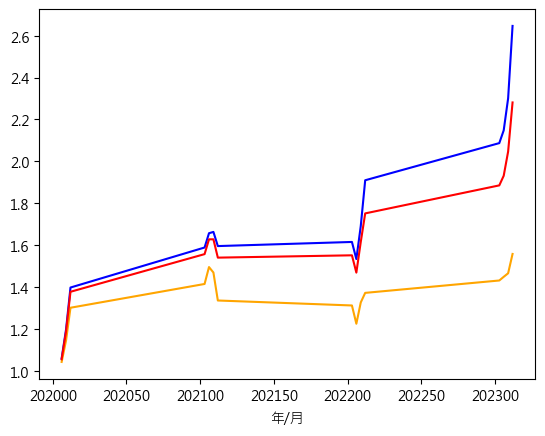

In [22]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #顯示中文
(test_data[selected].groupby('年/月').mean()['累積季報酬率'] + 1).cumprod().plot(color = 'blue')     #randomforest
(test_data[~selected].groupby('年/月').mean()['累積季報酬率'] + 1).cumprod().plot(color = 'orange')  #benchmark1
(test_data.groupby('年/月').mean()['累積季報酬率'] + 1).cumprod().plot(color = 'red')                #benchmark2

#### Step6.看一下樹長什麼樣子

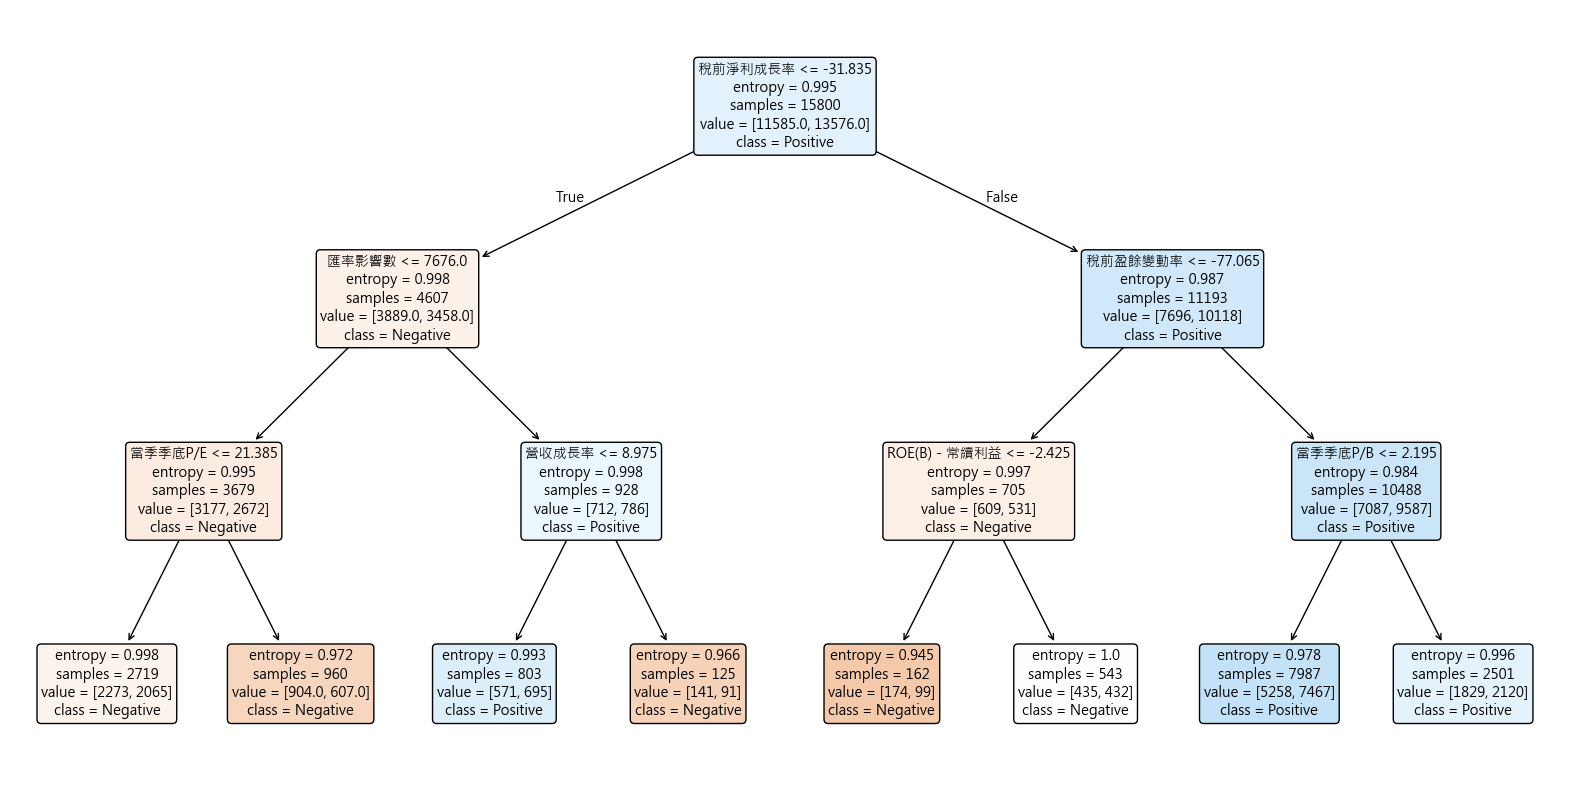

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 使用隨機森林的其中一棵樹
estimator = rf.estimators_[0]

# 畫出決策樹
plt.figure(figsize=(20, 10))
plot_tree(estimator, 
          feature_names=train_data.drop(columns='累積季報酬率').columns,
          class_names=['Negative', 'Positive'],
          filled=True, rounded=True, fontsize=10)
plt.show()